In [161]:
import numpy as np
#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
# import scipy.special
import pickle

from abc import ABC, abstractmethod

import math
import os

from skopt import gp_minimize, gbrt_minimize, forest_minimize
from skopt.space import Real, Integer


# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gymnasium.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [162]:
MAX_EPISODE_STEPS = 200

In [163]:
class Learning(ABC) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        
        self.env : gym.Env = gym.make('MountainCar-v0')
        self.rng = None
        self.seed = None

        self.alpha = alpha
        self.gamma = gamma
        self.spaceBins = spaceBins
        self.velBins = velBins

        self.spaceLinSpace = np.linspace(
            self.env.observation_space.low[0], 
            self.env.observation_space.high[0], spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            self.env.observation_space.low[1], 
            self.env.observation_space.high[1], 
            velBins + 1
        )


    def oneEpisode(self, episodeIdx : int, training : bool) :
        currentState = self.env.reset()[0]
        terminated = False
        totalReward = 0
        for episodeStep in range(0, MAX_EPISODE_STEPS) :
            action = self.chooseNextAction(currentState, episodeIdx, episodeStep, training)
            nextState, reward, terminated, _, _ = self.env.step(action)
            if training :
                self.updateFunction(currentState, nextState, reward, action, episodeIdx, episodeStep)

            currentState = nextState
            totalReward += reward
            if (terminated) :
                break
        
        return totalReward


    def learn(self, episodeNum : int, seed : int) -> np.ndarray :
        self.env = gym.Env = gym.make('MountainCar-v0')
        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward = self.oneEpisode(episodeIdx, True)
            rewardArray[episodeIdx] = episodeReward

            self.updateAfterEpisode(episodeNum)
        
        self.env.close()

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) :
        self.env = gym.Env = gym.make('MountainCar-v0', render_mode = "human" if display else None)
        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray = np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward = self.oneEpisode(episodeIdx, False)
            rewardArray[episodeIdx] = episodeReward

        self.env.close()
        return rewardArray
 
    def computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return (spaceSlot, velocitySlot)

    @abstractmethod
    def updateAfterEpisode(self, episodeIdx) :
        pass

    @abstractmethod
    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int : 
        pass

    @abstractmethod
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None:
        pass


# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

## Algoritmi

### Q-Learning
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [164]:
class QLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, self.env.action_space.n])
        self.epsilon = 1

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        spaceSlot, velSlot = self.computeSlots(state)
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)

        #eta = self.alpha / (1 + 0.5 * episodeIdx)
        target = reward + self.gamma * np.max(self.qFunction[nextSpaceSlot][nextVelSlot])
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)
        self.alpha = max(self.alpha - 1 / maxEpisodeNum, 0.001)

### SARSA
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [165]:
class SarsaLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1 

    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int:
        spaceSlot, velSlot = self.computeSlots(state)
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)
        nextAction = self.chooseNextAction(nextState, episodeIdx, episodeStep, True)

        target = reward + self.gamma * self.qFunction[nextSpaceSlot][nextVelSlot][nextAction]
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)
        self.alpha = max(self.alpha - 1 / maxEpisodeNum, 0.001)

### Expected-SARSA

Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma E_{\pi}[Q(S',A') | S'] - Q(S,A)]$

e

$E_{\pi}[Q(S',A') | S'] = \sum_{a} \pi(a | S')Q(S',a)$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [166]:
class ExpectedSarsaLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFunction : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1

    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int:
        spaceSlot, velSlot = self.computeSlots(state)
        if (training) :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        else :
            action = np.argmax(self.qFunction[spaceSlot, velSlot, :])
        
        return action

    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        spaceSlot, velSlot = self.computeSlots(currentState)
        nextQValue = self.computeExpectedQValue(nextState, episodeIdx, episodeStep)
        
        target = reward + self.gamma * nextQValue
        increment = self.alpha * (target - self.qFunction[spaceSlot][velSlot][action])

        self.qFunction[spaceSlot][velSlot][action] += increment

    def updateAfterEpisode(self, maxEpisodeNum):
        self.epsilon = max(self.epsilon - 2 / (maxEpisodeNum), 0.0)
        self.alpha = max(self.alpha - 1 / maxEpisodeNum, 0.001)
        pass


    def computeExpectedQValue(self, nextState, episodeIdx, episodeStep) :
        spaceSlot, velSlot = self.computeSlots(nextState)

        expectedQ = 0
        qMax = np.max(self.qFunction[spaceSlot, velSlot])
        greedyActions = 0
        for action in range(self.env.action_space.n) :
            if (self.qFunction[spaceSlot, velSlot, action] == qMax) :
                greedyActions += 1

        nonGreedyProb = self.epsilon / self.env.action_space.n
        greedyProb = (1 - self.epsilon) / greedyActions + nonGreedyProb
        for action in range(self.env.action_space.n) :
            if (self.qFunction[spaceSlot, velSlot, action] == qMax) :
                expectedQ += self.qFunction[spaceSlot, velSlot, action] * greedyProb
            else :
                expectedQ += self.qFunction[spaceSlot, velSlot, action] * nonGreedyProb
        
        return expectedQ

### Double Q-Learning

In [167]:
from numpy import ndarray


class DoubleQLearning(Learning) :

    def __init__(self, alpha : float, gamma : float, spaceBins : int, velBins : int) :
        super().__init__(alpha, gamma, spaceBins, velBins)
        self.qFun_1 : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.qFun_2 : np.ndarray = np.zeros([spaceBins, velBins, 3])
        self.epsilon = 1
        self.funChooseGenerator = None

    def learn(self, episodeNum: int, seed: int) -> ndarray:
        self.funChooseGenerator = np.random.default_rng(seed = seed + 30)
        return super().learn(episodeNum, seed)
    
    def test(self, episodeNum: int, seed: int, display: bool):
        self.funChooseGenerator = np.random.default_rng(seed = seed + 30)
        return super().test(episodeNum, seed, display)

    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        if (self.funChooseGenerator.random() < 0.5) :
            toUpdate = self.qFun_1
            other = self.qFun_2
        else :
            toUpdate = self.qFun_2
            other = self.qFun_1

        spaceSlot, velSlot = self.computeSlots(currentState)
        nextSpaceSlot, nextVelSlot = self.computeSlots(nextState)
        nextAction = np.argmax(toUpdate[nextSpaceSlot][nextVelSlot])
        
        target = reward + self.gamma * other[nextSpaceSlot][nextVelSlot][nextAction]
        increment = self.alpha * (target - toUpdate[spaceSlot][velSlot][action])

        toUpdate[spaceSlot][velSlot][action] += increment

    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int:
        spaceSlot, velSlot = self.computeSlots(state)
        if (training) :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.qFun_1[spaceSlot][velSlot] + self.qFun_2[spaceSlot][velSlot])
        else :
            action = np.argmax(self.qFun_1[spaceSlot][velSlot] + self.qFun_2[spaceSlot][velSlot])
        return action
        
    def updateAfterEpisode(self, episodeNum):
        self.epsilon = max(self.epsilon - 2 / (episodeNum), 0.0)
        self.alpha = max(self.alpha - 1 / episodeNum, 0.001)
        
    

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri; come iperparametri da sintonizzare sono stati considerati solamente due dei possibili, ovvero:
* $\alpha$, cioè il learning rate
* $\gamma$, cioè il fattore di sconto

Per quanto riguarda gli altri valori sono stati scelti empiricamente facendo qualche prova manuale:
* Per il parametro di esplorazione $\epsilon$ si è scelta un'inizializzazione ad $1$ con decremento lineare
* Numero di beans: Il numero di intervalli in cui suddividere lo stato dello spazio e della velocità sono stati supposti uguali e posti al valore $20$. La scelta è stata dettata dal fatto che si tratta di un valore che permette una suddivisione non eccessivamente fitta dei due stati pur mantenendo una grana abbastanza fine; lo spazio infatti è suddiviso in intervalli di dimensione $0.09$, mentre la velocità in intervalli di dimensione $0.007$

Essendo le singole Run di sintonizzazione piuttosto lunghe, i valori una volta calcolati vengono salvati su un file in modo tale da non doverli calcolare una seconda

In [168]:
class Tuner() :

    def __init__(self, LearnerClass : Learning, numberOfTuningEpisode : int, seed) :
        self.LearnerClass = LearnerClass
        self.numberOfTuningEpisode = numberOfTuningEpisode
        self.seed = seed
        self.attempt = 0

    def objective(self, params):
        alpha, gamma = params
        learner : Learning = self.LearnerClass(alpha, gamma, 20, 20)
        rewardArray = learner.learn(self.numberOfTuningEpisode, self.seed)
        avgReward = rewardArray.mean()
        print("Attempt >>> ", self.attempt)
        print("Tested Params >>> ", params)
        print("Result >>> ", -avgReward)
        print()
        self.attempt += 1
        return -avgReward
    
    def tune(self, calls, randomState, space) :
        self.attempt = 0
        # Esecuzione dell'ottimizzazione bayesiana
        results = gp_minimize(
            func = self.objective,       # La funzione obiettivo
            dimensions = space,     # Spazio degli iperparametri
            n_calls = calls,           # Numero di valutazioni della funzione obiettivo
            random_state = randomState,      # Per riproducibilità
        )
        
        bestParams = results.get("x")
        bestAttempt = np.argmin(results.get("func_vals"))
        print("Best Attempt >>> ", bestAttempt)
        print("Best Value >>> ", np.min(results.get("func_vals")))
        print("Best Params >>> ", bestParams )
        print()
        return bestParams


In [169]:
TUNING_SEED = 0

def tuneLearner(LearnerClass, bestParamsDict) -> list :
    if (not LearnerClass.__name__ in bestParamsDict) :
        space = [
            Real(0.01, 1.0, name='alpha'),
            Real(0.8, 0.99, name='gamma'),
        ]
        bestParams = Tuner(LearnerClass, 2_000, TUNING_SEED).tune(35, 1234, space)
        bestParamsDict[LearnerClass.__name__] = bestParams
        with open('BestParamsDictionary.pkl', 'wb') as f:
            pickle.dump(bestParamsDict, f)
    else :
        bestParams = bestParamsDict[LearnerClass.__name__]

    return bestParams

In [170]:
if (os.path.exists('./BestParamsDictionary.pkl')) :
    with open('BestParamsDictionary.pkl', 'rb') as f:
        bestParamsDict = pickle.load(f)
        print(bestParamsDict)
else :
    bestParamsDict = {}

tuneLearner(QLearning, bestParamsDict)
tuneLearner(SarsaLearning, bestParamsDict)
tuneLearner(ExpectedSarsaLearning, bestParamsDict)
tuneLearner(DoubleQLearning, bestParamsDict)

print(bestParamsDict)

{'QLearning': [0.7338267267488028, 0.99], 'SarsaLearning': [0.6256154783991632, 0.99], 'ExpectedSarsaLearning': [0.5826875792767965, 0.99], 'DoubleQLearning': [0.7281255267941072, 0.989842402584623]}
{'QLearning': [0.7338267267488028, 0.99], 'SarsaLearning': [0.6256154783991632, 0.99], 'ExpectedSarsaLearning': [0.5826875792767965, 0.99], 'DoubleQLearning': [0.7281255267941072, 0.989842402584623]}


In [171]:
print(bestParamsDict)

{'QLearning': [0.7338267267488028, 0.99], 'SarsaLearning': [0.6256154783991632, 0.99], 'ExpectedSarsaLearning': [0.5826875792767965, 0.99], 'DoubleQLearning': [0.7281255267941072, 0.989842402584623]}


## Addestramento

In [172]:
def plotRewardsTrend(rewardArray : np.ndarray, episodeNum : int) :
    plt.figure(figsize=(15,5))
    plt.plot(np.array(rewardArray))
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(15,5))
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.show()
    plt.clf()

In [173]:
TRAIN_SEED = 10

def trainLearner(LearnerClass, trainDict, bestParamsDict, episodeNum) -> Learning :
    dictKey = (LearnerClass.__name__, episodeNum)
    if (not dictKey in trainDict) :
        bestParams = bestParamsDict[LearnerClass.__name__]
        learner : Learning = LearnerClass(bestParams[0], bestParams[1], 20, 20)
        rewardArray = learner.learn(episodeNum, TRAIN_SEED)
        
        trainDict[dictKey] = [learner, rewardArray]
        with open('TrainDictionary.pkl', 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        learner : Learning = trainDict[dictKey][0]
        rewardArray = trainDict[dictKey][1]
    
    plotRewardsTrend(rewardArray, episodeNum)

    return learner

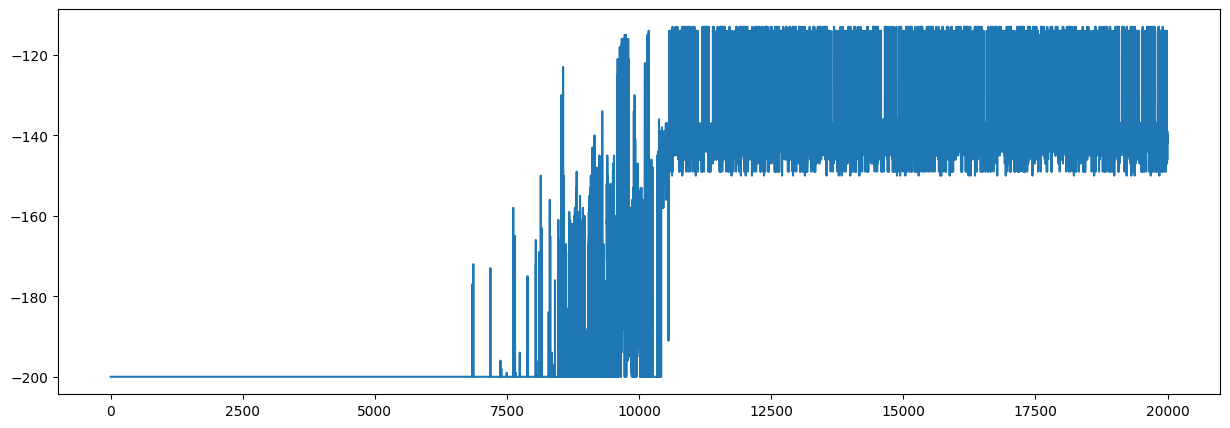

<Figure size 640x480 with 0 Axes>

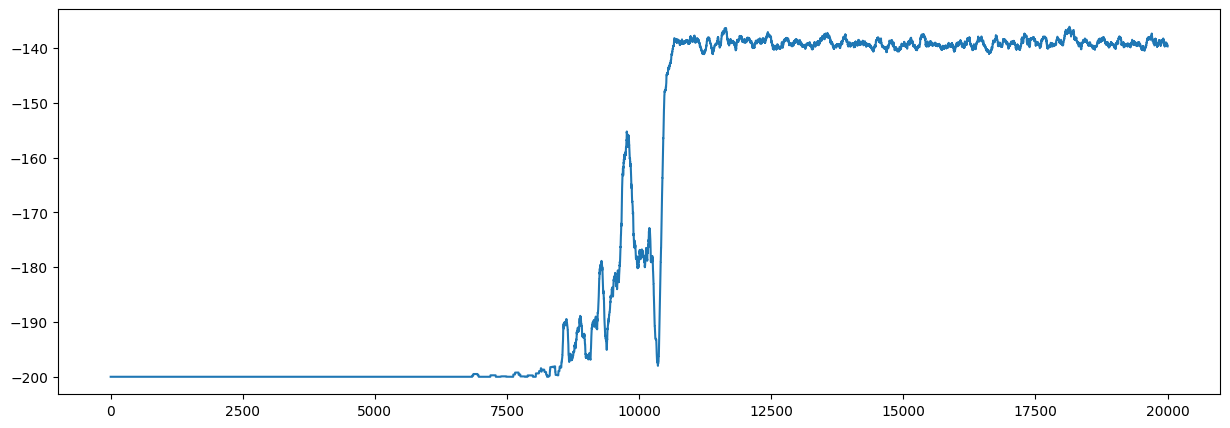

<Figure size 640x480 with 0 Axes>

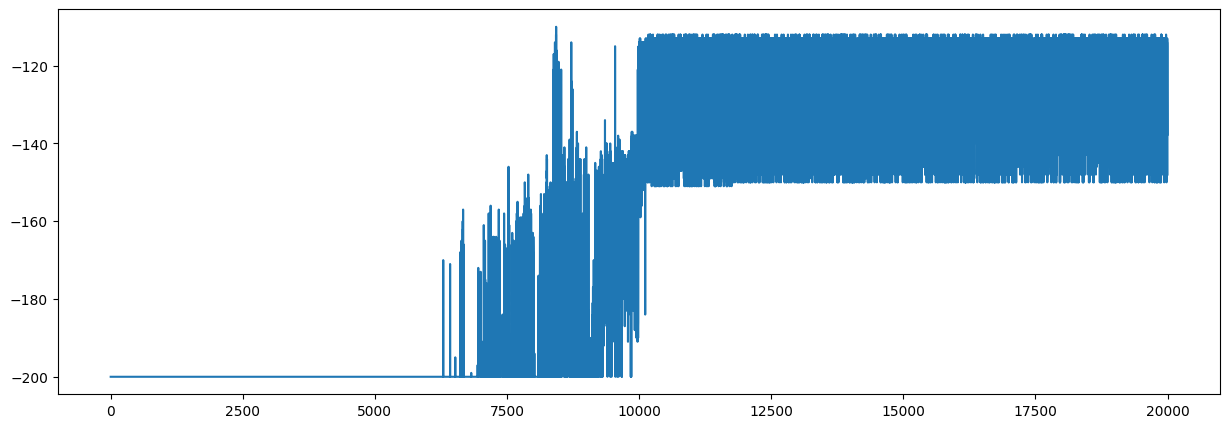

<Figure size 640x480 with 0 Axes>

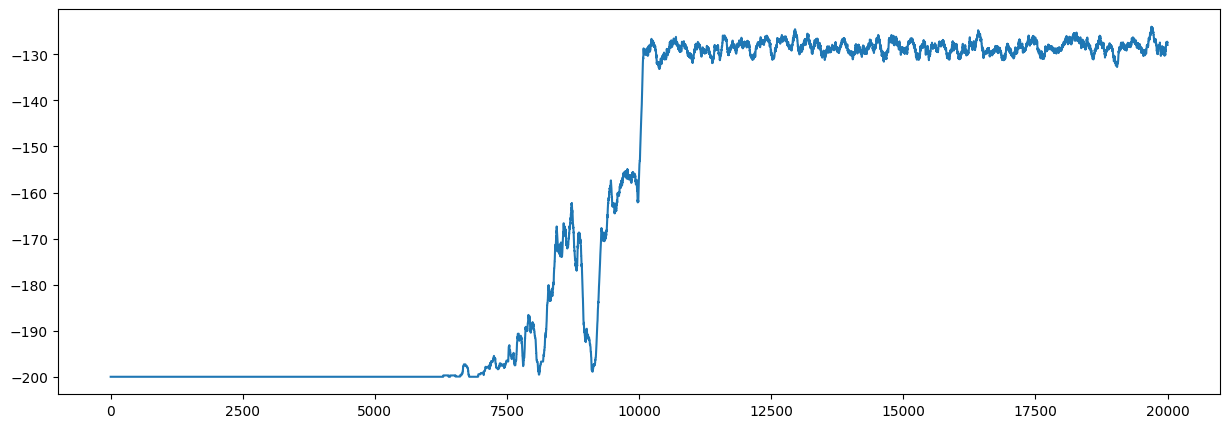

<Figure size 640x480 with 0 Axes>

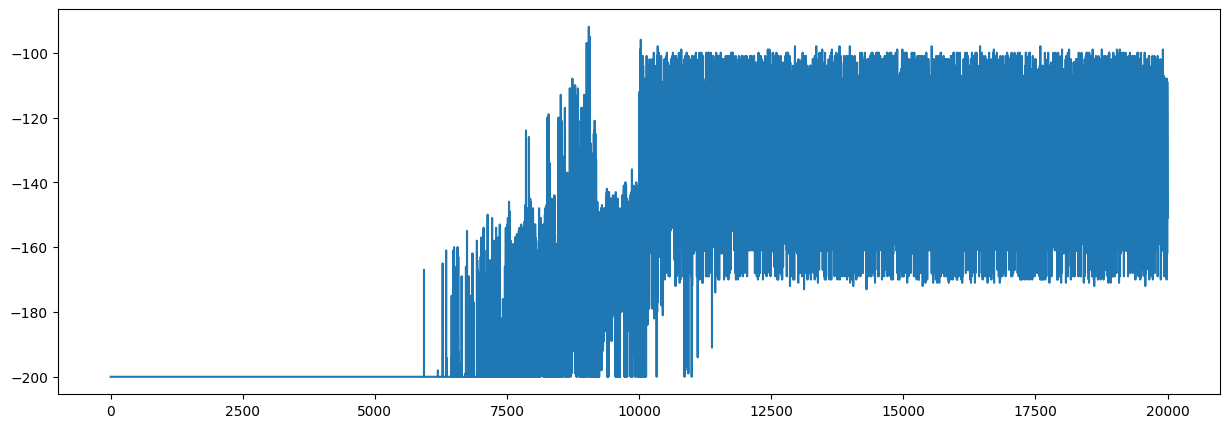

<Figure size 640x480 with 0 Axes>

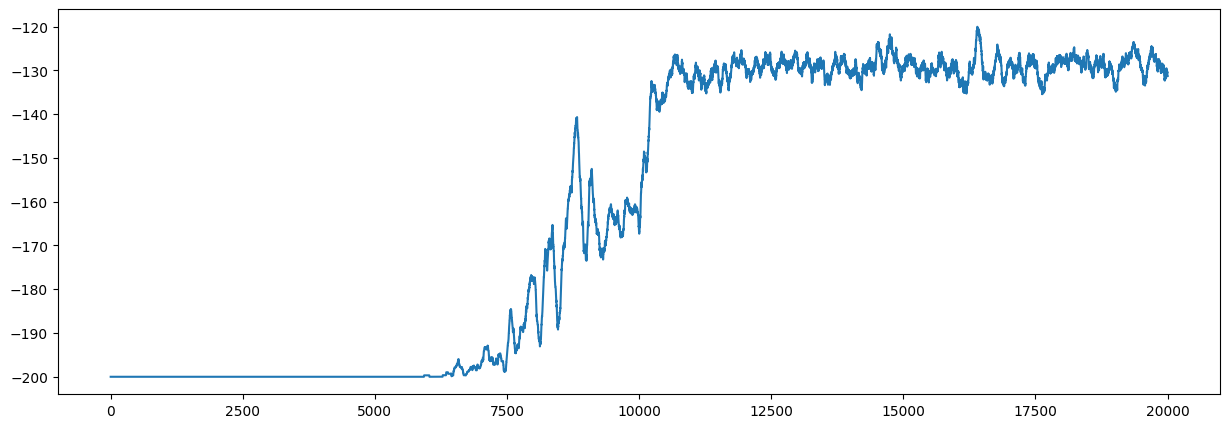

<Figure size 640x480 with 0 Axes>

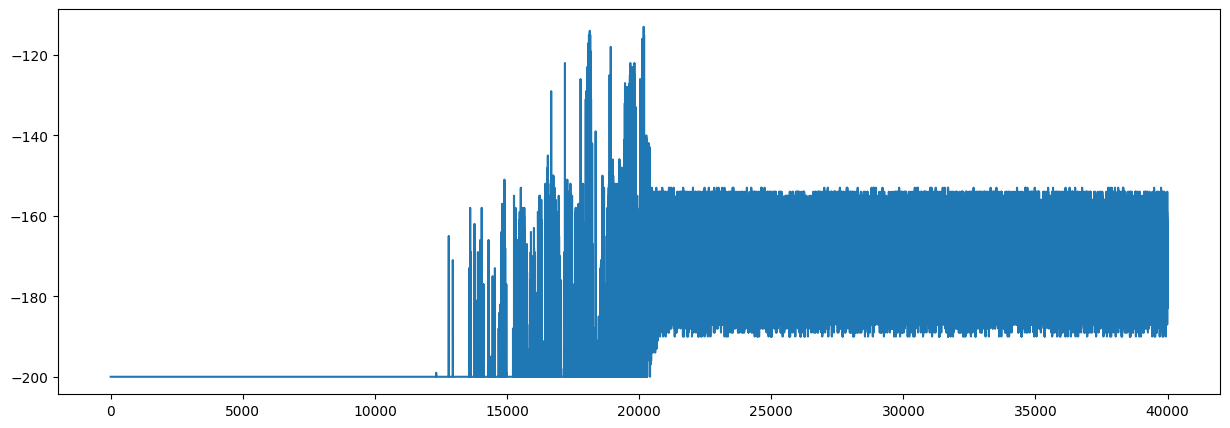

<Figure size 640x480 with 0 Axes>

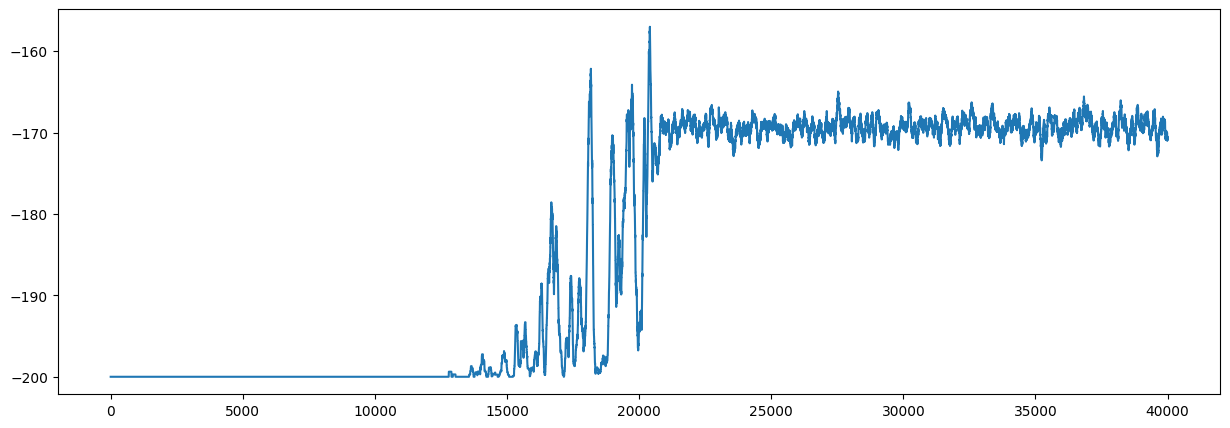

<Figure size 640x480 with 0 Axes>

In [174]:
if (os.path.exists('./TrainDictionary.pkl')) :
    with open('TrainDictionary.pkl', 'rb') as f:
        trainDict = pickle.load(f)
else :
    trainDict = {}

qLearner = trainLearner(QLearning, trainDict, bestParamsDict, 20_000)
sarsaLearner = trainLearner(SarsaLearning, trainDict, bestParamsDict, 20_000)
expectedSarsaLearner = trainLearner(ExpectedSarsaLearning, trainDict, bestParamsDict, 20_000)
doubleQLearner = trainLearner(DoubleQLearning, trainDict, bestParamsDict, 40_000)

## Testing

In [175]:
TEST_SEED = 20

In [191]:
qLearnerTestArray = qLearner.test(100, TEST_SEED, False)
sarsaLearnerTestArray = sarsaLearner.test(100, TEST_SEED, False)
expectedSarsaLearnerTestArray = expectedSarsaLearner.test(100, TEST_SEED, False)
doubleQLearnerTestArray = doubleQLearner.test(100, TEST_SEED, False)

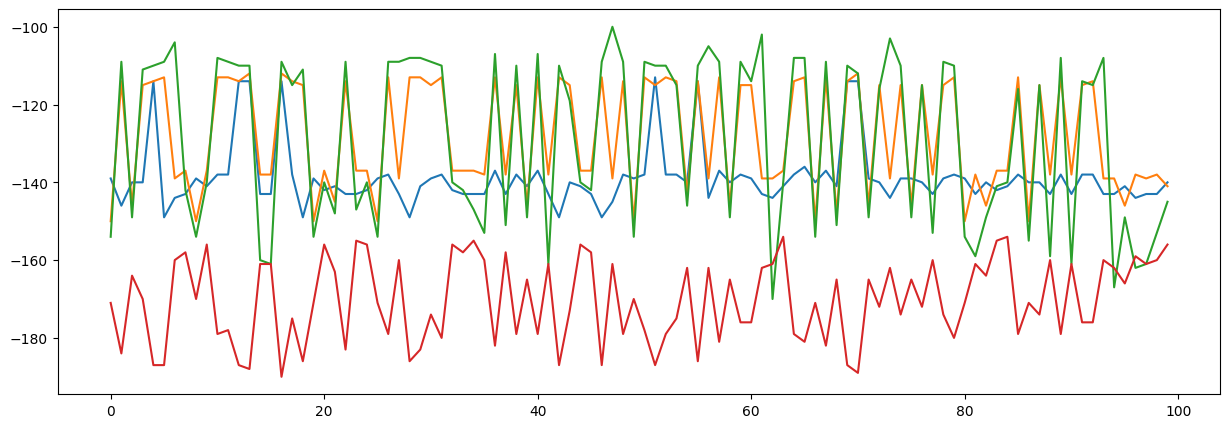

In [192]:
plt.figure(figsize = (15,5))
plt.plot(qLearnerTestArray)
plt.plot(sarsaLearnerTestArray)
plt.plot(expectedSarsaLearnerTestArray)
plt.plot(doubleQLearnerTestArray)

## Confronto

# Soluzione con approssimazione

## Approssimazione Lineare

## Approssimazione con NQN